Title: Simple DNN trainer for image classification of different compressed image sizes.

Last Update: 08/15/2023

Developers: Rohan Soni, Homa Esfahanizadeh

Based on Simple DNN Classifier by Homa Esfahanizadeh: https://colab.research.google.com/drive/1a5DF6P7au89G4uuy0gbCg0VhJKu3LSaj?usp=sharing

In [ ]:
# Install Necessary Packages
!pip install torch pytorch-lightning==1.9.4

In [ ]:
# Import Necessary Libraries
import numpy as np
import json
import torch
import matplotlib.pyplot as plt

import torchvision
import pytorch_lightning as pl
from tqdm import tqdm
from pytorch_lightning import Trainer, seed_everything

import torch.nn as nn
from torch.nn import functional as F

import math
import logging
logging.getLogger().setLevel(logging.ERROR)

from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#mount Google Drive for access to folders (change if using program locally)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parameters and Constants
DATA_SAVE_PATH = "drive/MyDrive/Colab/Classification Results/data/" # Location for saved classification datapoints
FIG_SAVE_PATH = "drive/MyDrive/Colab/Classification Results/figures/" # Location for saving graphical results
ATTR_LOCATION = "drive/MyDrive/Colab/male_or_female.txt" #Location for all male/female labels
ZIPS_PATH = "drive/MyDrive/Colab/Zips/" #Location for storing zip files of all images (unzipping locally is faster)

lr = 1e-4 # learning rate
N_CLASSIFIER_TRAINING_EPOCHS = 10 # Number of epochs for training classifiers

#images will always be squares for this example (easier to iterate with same x and y dimension)
min_img_size = 5
max_img_size = 50
interval = 5

In [ ]:
# Set Cpmputing Device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'   #cuda:0 or cuda:1 for our 2-GPU testbed
num_gpus = 1 if device=='cuda:0' else 0
print(device)

cuda:0


In [ ]:
# Set Random Seed
seed = 1
seed_everything(seed, workers=True)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Numpy RNG
np.random.seed(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
#my own class created for converting images and labels to tensors and np arrays, respectively
def image_database(num_images_start, num_images_end, image_size, gray_or_color, randomness, train):
    convert_tensor = transforms.ToTensor()

    #convert male or female text file to array
    y_train = []
    labels_file = open(ATTR_LOCATION).readlines() #length 202598 (all labels)
    for i in range(num_images_start, num_images_end):
      y_train.append(float(labels_file[i][0])) #grabs only the 0 or 1 as a float
    y_train = np.array(y_train) #creates ndarray from the list of male/female values
    #y_train = torch.FloatTensor(y_train) #NOT USEFUL (wrong type) creates a tensor out of that list

    X_train = []
    for i in range(num_images_start+1, num_images_end+1):

      #create 6-character number name
      new_filename = str(i)
      for j in range(6 - len(new_filename)):
        new_filename = "0" + new_filename

      if train:
        img_folder = f"60ksamples_size{image_size[0]}x{image_size[1]}"
      else:
        img_folder = f"10ksamples_size{image_size[0]}x{image_size[1]}"

      #img = Image.open(f"drive/MyDrive/Colab/Batches/{img_folder}/" + str(new_filename) + f"_processed_size{image_size[0]}x{image_size[1]}.jpg")
      img = Image.open(f"{img_folder}/{str(new_filename)}_processed_size{image_size[0]}x{image_size[1]}.jpg")
      img_tensor = convert_tensor(img) #has a size equal to the total number of pixels
      X_train.append(img_tensor)
      if i % 2000 == 0: #change 1000 to different value for more/less frequent updates
        print(f"Finished {i}th image.")

    X_train = torch.stack([i for i in X_train]) #concatenate list of image tensors to a single tensor
    X_train = X_train.reshape(-1, image_size[0]*image_size[1]).float()
    print(type(X_train), X_train.size, type(y_train), y_train.size)
    synthetic = SyntheticDataset(X_train, y_train)
    return [synthetic, X_train, y_train]

#(previously created class) for conversion to Synthetic dataset after creating tensor and ndarray
class SyntheticDataset(Dataset):
    def __init__(self, data1, data2):
        self.data1 = data1
        self.data2 = data2

    def __getitem__(self, index):
        x = self.data1[index]
        z = self.data2[index]
        return x, z

    def __len__(self):
        return len(self.data1)

In [ ]:
# %% Dense neural network that is used as Classifier

class DenseClassifier(nn.Module): #things in parentheses after class definition are classes from which other functions can be inherited/used (makes it so that you don't have to define them all again, kind of like importing)
    def __init__(self, in_nodes, hidden_nodes=20):
        super(DenseClassifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_nodes, hidden_nodes),
            nn.ReLU(),
            nn.Linear(hidden_nodes, hidden_nodes),
            nn.ReLU(),
            nn.Linear(hidden_nodes, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(device)
        return self.main(x)

    def train_classifier(self, train_loader, epochs=N_CLASSIFIER_TRAINING_EPOCHS):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-4, momentum=0.9) #put current network parameters into SGD algorithm
        for epoch in tqdm(range(epochs)):
            self.train()
            train_loss = 0
            for x, y in train_loader:
                x, y = x.to(device).float(), y.to(device).float()
                y_hat = self(x).squeeze()
                loss = F.binary_cross_entropy(y_hat, y, reduction="sum")
                train_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Average loss per sample
            # If avg loss per elements, divide again by size of each sample
            avg_train_loss = train_loss / len(train_loader.dataset)
            print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')

    def evaluate(self, test_loader):
        self.eval()
        test_data, test_labels = test_loader.dataset.data1, test_loader.dataset.data2
        preds = self(test_data.to(device)).squeeze()
        y_true = test_labels
        y_score = preds.detach().cpu().numpy()

        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        test_loss = F.binary_cross_entropy(torch.from_numpy(y_true).float(), torch.from_numpy(y_score).float())

        return fpr, tpr, thresholds, auc, test_loss

Now doing size 5x5.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ab8b292b0> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<class 'torch.Tensor'> <built-in

 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

====> Epoch: 0 Average loss: 0.6561


 20%|██        | 2/10 [00:02<00:07,  1.00it/s]

====> Epoch: 1 Average loss: 0.5756


 30%|███       | 3/10 [00:02<00:06,  1.02it/s]

====> Epoch: 2 Average loss: 0.5497


 40%|████      | 4/10 [00:03<00:05,  1.04it/s]

====> Epoch: 3 Average loss: 0.5339


 50%|█████     | 5/10 [00:04<00:04,  1.05it/s]

====> Epoch: 4 Average loss: 0.5279


 60%|██████    | 6/10 [00:05<00:03,  1.06it/s]

====> Epoch: 5 Average loss: 0.5224


 70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

====> Epoch: 6 Average loss: 0.5207


 80%|████████  | 8/10 [00:07<00:01,  1.07it/s]

====> Epoch: 7 Average loss: 0.5192


 90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

====> Epoch: 8 Average loss: 0.5176


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

====> Epoch: 9 Average loss: 0.5166


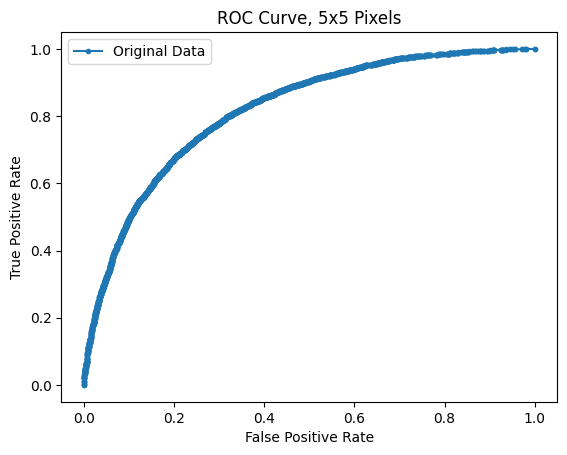

AUC:  0.817023143414922


Now doing size 10x10.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ac2e70d60> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cla

 10%|█         | 1/10 [00:01<00:09,  1.04s/it]

====> Epoch: 0 Average loss: 0.6220


 20%|██        | 2/10 [00:02<00:08,  1.01s/it]

====> Epoch: 1 Average loss: 0.5151


 30%|███       | 3/10 [00:03<00:07,  1.00s/it]

====> Epoch: 2 Average loss: 0.4800


 40%|████      | 4/10 [00:04<00:05,  1.01it/s]

====> Epoch: 3 Average loss: 0.4638


 50%|█████     | 5/10 [00:04<00:04,  1.02it/s]

====> Epoch: 4 Average loss: 0.4604


 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]

====> Epoch: 5 Average loss: 0.4502


 70%|███████   | 7/10 [00:06<00:02,  1.07it/s]

====> Epoch: 6 Average loss: 0.4446


 80%|████████  | 8/10 [00:07<00:01,  1.07it/s]

====> Epoch: 7 Average loss: 0.4405


 90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

====> Epoch: 8 Average loss: 0.4354


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

====> Epoch: 9 Average loss: 0.4295


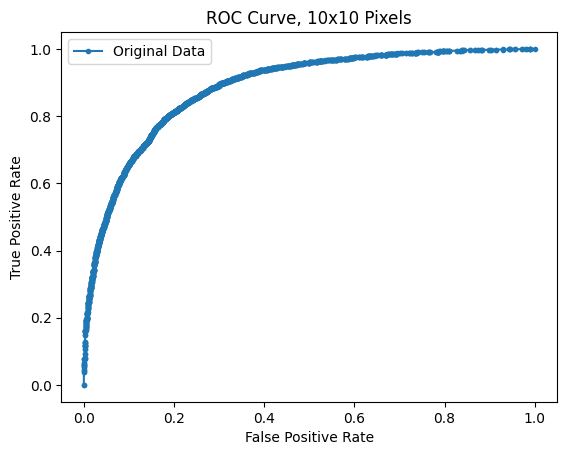

AUC:  0.8859474402012721


Now doing size 15x15.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ac1274c20> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:00<00:08,  1.04it/s]

====> Epoch: 0 Average loss: 0.5926


 20%|██        | 2/10 [00:01<00:07,  1.05it/s]

====> Epoch: 1 Average loss: 0.4655


 30%|███       | 3/10 [00:02<00:06,  1.04it/s]

====> Epoch: 2 Average loss: 0.4366


 40%|████      | 4/10 [00:03<00:05,  1.02it/s]

====> Epoch: 3 Average loss: 0.4127


 50%|█████     | 5/10 [00:04<00:04,  1.01it/s]

====> Epoch: 4 Average loss: 0.3994


 60%|██████    | 6/10 [00:05<00:04,  1.00s/it]

====> Epoch: 5 Average loss: 0.3936


 70%|███████   | 7/10 [00:06<00:02,  1.00it/s]

====> Epoch: 6 Average loss: 0.3843


 80%|████████  | 8/10 [00:07<00:01,  1.02it/s]

====> Epoch: 7 Average loss: 0.3747


 90%|█████████ | 9/10 [00:08<00:00,  1.04it/s]

====> Epoch: 8 Average loss: 0.3741


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

====> Epoch: 9 Average loss: 0.3693


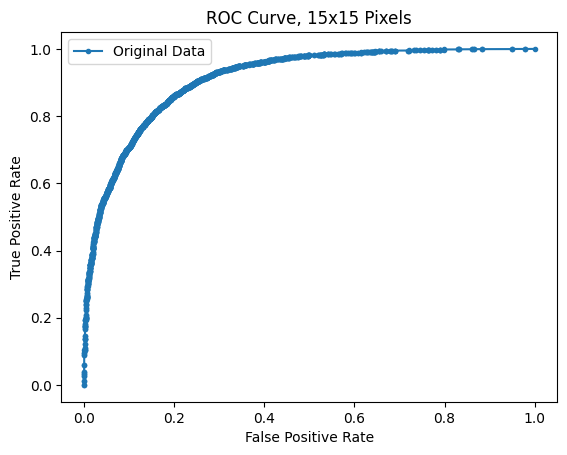

AUC:  0.9114535765093406


Now doing size 20x20.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ab8c9e430> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:00<00:08,  1.01it/s]

====> Epoch: 0 Average loss: 0.5681


 20%|██        | 2/10 [00:01<00:07,  1.02it/s]

====> Epoch: 1 Average loss: 0.4247


 30%|███       | 3/10 [00:02<00:06,  1.01it/s]

====> Epoch: 2 Average loss: 0.3859


 40%|████      | 4/10 [00:03<00:05,  1.01it/s]

====> Epoch: 3 Average loss: 0.3588


 50%|█████     | 5/10 [00:04<00:04,  1.01it/s]

====> Epoch: 4 Average loss: 0.3530


 60%|██████    | 6/10 [00:06<00:04,  1.02s/it]

====> Epoch: 5 Average loss: 0.3356


 70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

====> Epoch: 6 Average loss: 0.3202


 80%|████████  | 8/10 [00:08<00:02,  1.04s/it]

====> Epoch: 7 Average loss: 0.3238


 90%|█████████ | 9/10 [00:09<00:01,  1.04s/it]

====> Epoch: 8 Average loss: 0.3154


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

====> Epoch: 9 Average loss: 0.3061


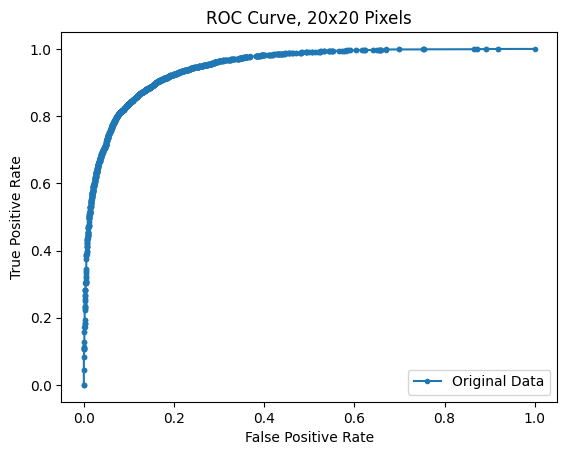

AUC:  0.9461491291291588


Now doing size 25x25.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ab8447330> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

====> Epoch: 0 Average loss: 0.5386


 20%|██        | 2/10 [00:02<00:08,  1.02s/it]

====> Epoch: 1 Average loss: 0.3970


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

====> Epoch: 2 Average loss: 0.3548


 40%|████      | 4/10 [00:04<00:06,  1.01s/it]

====> Epoch: 3 Average loss: 0.3358


 50%|█████     | 5/10 [00:05<00:05,  1.01s/it]

====> Epoch: 4 Average loss: 0.3185


 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

====> Epoch: 5 Average loss: 0.3120


 70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

====> Epoch: 6 Average loss: 0.3008


 80%|████████  | 8/10 [00:08<00:02,  1.03s/it]

====> Epoch: 7 Average loss: 0.2962


 90%|█████████ | 9/10 [00:09<00:01,  1.05s/it]

====> Epoch: 8 Average loss: 0.2828


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

====> Epoch: 9 Average loss: 0.2797


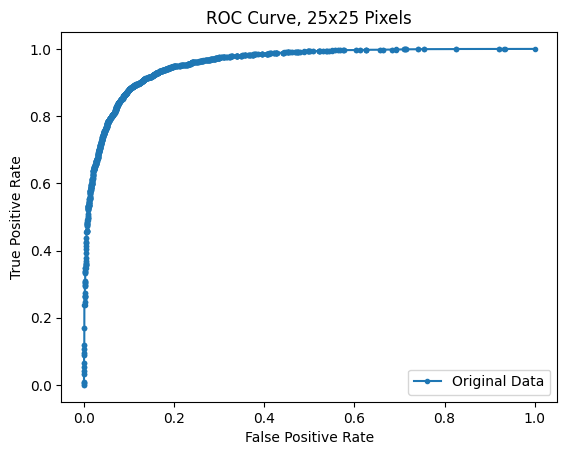

AUC:  0.956005268442291


Now doing size 30x30.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ab82b6b10> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cla

 10%|█         | 1/10 [00:01<00:09,  1.07s/it]

====> Epoch: 0 Average loss: 0.5500


 20%|██        | 2/10 [00:02<00:08,  1.06s/it]

====> Epoch: 1 Average loss: 0.3677


 30%|███       | 3/10 [00:03<00:07,  1.06s/it]

====> Epoch: 2 Average loss: 0.3171


 40%|████      | 4/10 [00:04<00:06,  1.05s/it]

====> Epoch: 3 Average loss: 0.2902


 50%|█████     | 5/10 [00:05<00:05,  1.05s/it]

====> Epoch: 4 Average loss: 0.2752


 60%|██████    | 6/10 [00:06<00:04,  1.06s/it]

====> Epoch: 5 Average loss: 0.2671


 70%|███████   | 7/10 [00:07<00:03,  1.06s/it]

====> Epoch: 6 Average loss: 0.2633


 80%|████████  | 8/10 [00:08<00:02,  1.08s/it]

====> Epoch: 7 Average loss: 0.2592


 90%|█████████ | 9/10 [00:09<00:01,  1.09s/it]

====> Epoch: 8 Average loss: 0.2466


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

====> Epoch: 9 Average loss: 0.2455


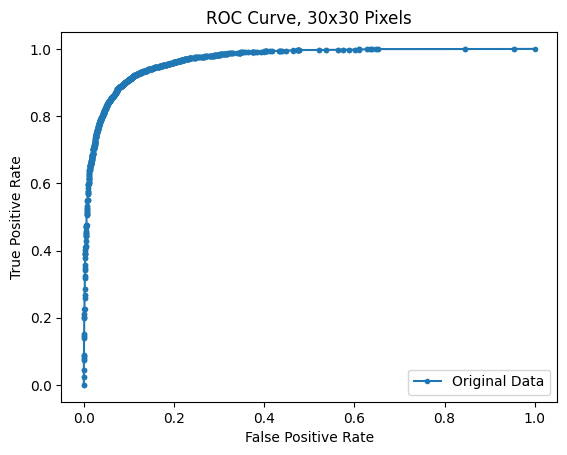

AUC:  0.9668322399649283


Now doing size 35x35.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ac10a5120> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:01<00:10,  1.14s/it]

====> Epoch: 0 Average loss: 0.5067


 20%|██        | 2/10 [00:02<00:09,  1.13s/it]

====> Epoch: 1 Average loss: 0.3428


 30%|███       | 3/10 [00:03<00:07,  1.13s/it]

====> Epoch: 2 Average loss: 0.3008


 40%|████      | 4/10 [00:04<00:06,  1.12s/it]

====> Epoch: 3 Average loss: 0.2812


 50%|█████     | 5/10 [00:05<00:05,  1.12s/it]

====> Epoch: 4 Average loss: 0.2750


 60%|██████    | 6/10 [00:06<00:04,  1.12s/it]

====> Epoch: 5 Average loss: 0.2546


 70%|███████   | 7/10 [00:07<00:03,  1.13s/it]

====> Epoch: 6 Average loss: 0.2548


 80%|████████  | 8/10 [00:09<00:02,  1.16s/it]

====> Epoch: 7 Average loss: 0.2441


 90%|█████████ | 9/10 [00:10<00:01,  1.18s/it]

====> Epoch: 8 Average loss: 0.2343


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

====> Epoch: 9 Average loss: 0.2408


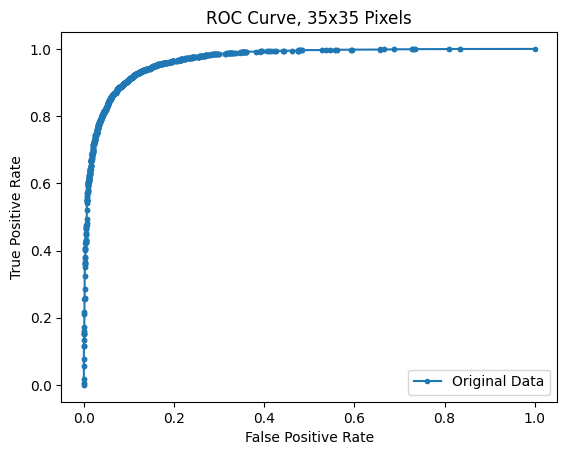

AUC:  0.9676556029542319


Now doing size 40x40.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ac2f42d40> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:01<00:10,  1.16s/it]

====> Epoch: 0 Average loss: 0.4981


 20%|██        | 2/10 [00:02<00:09,  1.14s/it]

====> Epoch: 1 Average loss: 0.3428


 30%|███       | 3/10 [00:03<00:08,  1.14s/it]

====> Epoch: 2 Average loss: 0.2978


 40%|████      | 4/10 [00:04<00:06,  1.15s/it]

====> Epoch: 3 Average loss: 0.2841


 50%|█████     | 5/10 [00:05<00:05,  1.16s/it]

====> Epoch: 4 Average loss: 0.2623


 60%|██████    | 6/10 [00:06<00:04,  1.16s/it]

====> Epoch: 5 Average loss: 0.2568


 70%|███████   | 7/10 [00:08<00:03,  1.19s/it]

====> Epoch: 6 Average loss: 0.2512


 80%|████████  | 8/10 [00:09<00:02,  1.21s/it]

====> Epoch: 7 Average loss: 0.2500


 90%|█████████ | 9/10 [00:10<00:01,  1.23s/it]

====> Epoch: 8 Average loss: 0.2360


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]

====> Epoch: 9 Average loss: 0.2346


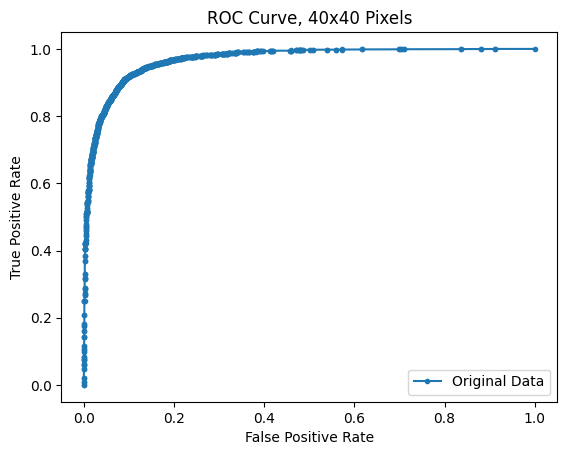

AUC:  0.9685030801497259


Now doing size 45x45.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ab0dada80> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:01<00:10,  1.21s/it]

====> Epoch: 0 Average loss: 0.4912


 20%|██        | 2/10 [00:02<00:09,  1.20s/it]

====> Epoch: 1 Average loss: 0.3323


 30%|███       | 3/10 [00:03<00:08,  1.22s/it]

====> Epoch: 2 Average loss: 0.2894


 40%|████      | 4/10 [00:04<00:07,  1.21s/it]

====> Epoch: 3 Average loss: 0.2709


 50%|█████     | 5/10 [00:06<00:06,  1.24s/it]

====> Epoch: 4 Average loss: 0.2534


 60%|██████    | 6/10 [00:07<00:04,  1.24s/it]

====> Epoch: 5 Average loss: 0.2534


 70%|███████   | 7/10 [00:08<00:03,  1.26s/it]

====> Epoch: 6 Average loss: 0.2340


 80%|████████  | 8/10 [00:09<00:02,  1.26s/it]

====> Epoch: 7 Average loss: 0.2349


 90%|█████████ | 9/10 [00:11<00:01,  1.24s/it]

====> Epoch: 8 Average loss: 0.2267


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]

====> Epoch: 9 Average loss: 0.2298


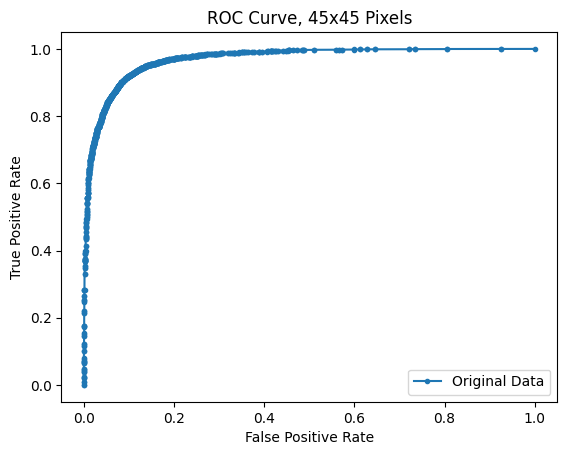

AUC:  0.9694904115529401


Now doing size 50x50.

Finished 2000th image.
Finished 4000th image.
Finished 6000th image.
Finished 8000th image.
Finished 10000th image.
Finished 12000th image.
Finished 14000th image.
Finished 16000th image.
Finished 18000th image.
Finished 20000th image.
Finished 22000th image.
Finished 24000th image.
Finished 26000th image.
Finished 28000th image.
Finished 30000th image.
Finished 32000th image.
Finished 34000th image.
Finished 36000th image.
Finished 38000th image.
Finished 40000th image.
Finished 42000th image.
Finished 44000th image.
Finished 46000th image.
Finished 48000th image.
Finished 50000th image.
Finished 52000th image.
Finished 54000th image.
Finished 56000th image.
Finished 58000th image.
Finished 60000th image.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x785ac0fb31f0> <class 'numpy.ndarray'> 60000
Finished 62000th image.
Finished 64000th image.
Finished 66000th image.
Finished 68000th image.
Finished 70000th image.
<cl

 10%|█         | 1/10 [00:01<00:11,  1.27s/it]

====> Epoch: 0 Average loss: 0.4836


 20%|██        | 2/10 [00:02<00:10,  1.28s/it]

====> Epoch: 1 Average loss: 0.3150


 30%|███       | 3/10 [00:03<00:09,  1.30s/it]

====> Epoch: 2 Average loss: 0.2873


 40%|████      | 4/10 [00:05<00:07,  1.32s/it]

====> Epoch: 3 Average loss: 0.2685


 50%|█████     | 5/10 [00:06<00:06,  1.33s/it]

====> Epoch: 4 Average loss: 0.2478


 60%|██████    | 6/10 [00:07<00:05,  1.32s/it]

====> Epoch: 5 Average loss: 0.2411


 70%|███████   | 7/10 [00:09<00:03,  1.30s/it]

====> Epoch: 6 Average loss: 0.2354


 80%|████████  | 8/10 [00:10<00:02,  1.29s/it]

====> Epoch: 7 Average loss: 0.2295


 90%|█████████ | 9/10 [00:11<00:01,  1.30s/it]

====> Epoch: 8 Average loss: 0.2242


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]

====> Epoch: 9 Average loss: 0.2174


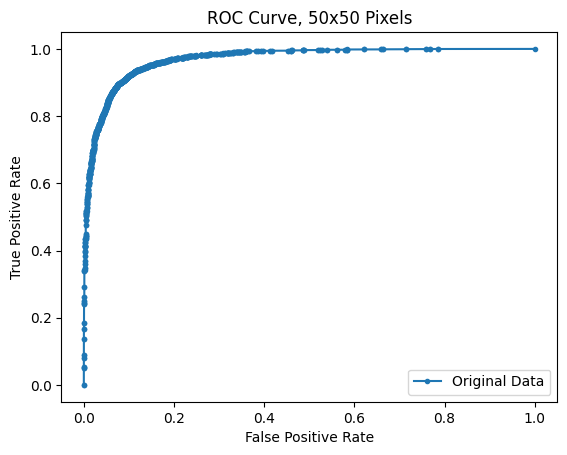

AUC:  0.9695846985085548


In [ ]:
#copied import statements for running this cell alone
import os
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image

tprs = []
fprs = []
thresholds = []
auc_list = []

for img_sizes in range(min_img_size, max_img_size+interval, interval): #DNN analysis for multiples of 5 from 5 to 50
  #currently only works for squares because they have the same dimension
  img_size = (img_sizes, img_sizes)

  #print current image size
  if img_sizes == min_img_size:
    print(f"Now doing size {img_size[0]}x{img_size[1]}.\n")
  else:
    print(f"\n\nNow doing size {img_size[0]}x{img_size[1]}.\n")

  os.system(f"unzip {ZIPS_PATH}10ksamples_size{img_size[0]}x{img_size[1]}")
  os.system(f"unzip {ZIPS_PATH}60ksamples_size{img_size[0]}x{img_size[1]}")

  # Constructing/Loading Dataset 1: CelebA Faces
  # The goal here is comparing I(X,Y)
  # X is a compressed image of a random celebrity
  # Y = L(X) represents if the the celebrity is male or female

  BATCH_SIZE = 100 # Batch size for training classifiers

  og_train_dataset, X_train, y_train = image_database(0, 60000, img_size, "gray", False, True) #get train dataset from first 60000 CelebA images
  og_test_dataset, X_test, y_test = image_database(60000, 70000, img_size, "gray", False, False) #get test dataset from next 10000 images

  og_train_loader = DataLoader(og_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  og_test_loader = DataLoader(og_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  N_FEATURES = X_test.shape[1] # Number of features per sample (total number of pixels)
  GRADIENT_BATCH_SIZE =  X_test.shape[0]/BATCH_SIZE  # How many gradients get accumulated before update (zero_grad)


  # %% Experiments: Training Classifier
  model = DenseClassifier(N_FEATURES).to(device)
  model.train_classifier(og_train_loader, epochs=N_CLASSIFIER_TRAINING_EPOCHS) # Original Data
  og_fpr, og_tpr, og_thresholds, og_auc, og_test_loss = model.evaluate(og_test_loader)

  f = open(DATA_SAVE_PATH + f'og_data_roc_auc_size{img_size[0]}x{img_size[1]}.json', "w")
  json.dump({"fpr": og_fpr.tolist(), "tpr": og_tpr.tolist(), "thresholds": og_thresholds.tolist()}, f)

  #add to list of ALL ROC curves for plotting all on same graph at end
  tprs.append(og_tpr.tolist())
  fprs.append(og_fpr.tolist())
  thresholds.append(og_thresholds.tolist())

  #for AUC v. compression graph
  auc_list.append(og_auc)

  # # %% Printing ROC curves
  plt.figure()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate' )
  plt.plot(og_fpr, og_tpr, marker='.', label='Original Data')
  plt.legend()
  plt.title(f"ROC Curve, {img_size[0]}x{img_size[1]} Pixels")
  plt.savefig(FIG_SAVE_PATH + f'ROC_size{img_size[0]}x{img_size[1]}.png')
  plt.show(FIG_SAVE_PATH + f'ROC_size{img_size[0]}x{img_size[1]}.png' )

  #save data for later, not just locally
  aucs = open(DATA_SAVE_PATH + "auc_list.txt", "a")
  aucs.write(str(og_auc) + "\n")
  aucs.close()

  #print AUC value
  print("AUC: ", og_auc)

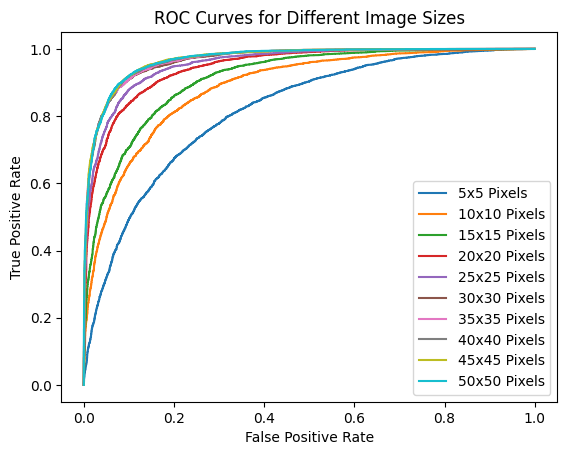

In [ ]:
#plot all ROC curves on same graph
sizes = [i for i in range(min_img_size, max_img_size+interval, interval)]
legend = []
plt.figure()
for i, fpr in enumerate(fprs):
  plt.plot(fpr, tprs[i])
  legend.append(f"{sizes[i]}x{sizes[i]} Pixels")

plt.legend(legend, loc="lower right")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curves for Different Image Sizes")
plt.savefig(FIG_SAVE_PATH + "All_ROC_Curves.png")
plt.show()

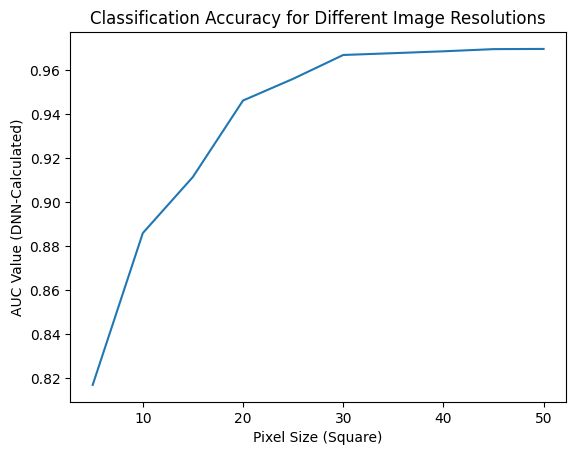

In [ ]:
#plot all AUC values as a function of image size (higher image sizes should correspond to higher AUC, but plateau)
img_sizes = [i for i in range(5, 55, 5)]
plt.plot(img_sizes, auc_list)
plt.xlabel("Pixel Size (Square)")
plt.ylabel("AUC Value (DNN-Calculated)")
plt.title("Classification Accuracy for Different Image Resolutions")
plt.savefig(FIG_SAVE_PATH + "AUC_vs_Compression.png")